Performance Metrics:
Total P&L: 198.90
Sharpe Ratio: 1.48
Max Drawdown: 3.55
Max Drawdown%: 1.78
Average Invested Value: 0.73
Total Trades: 575.00
Total Invested value: 419.98
Trades:
           start_date            end_date  entry_nifty  entry_banknifty  \
0 2021-01-07 15:25:00 2021-01-08 09:15:00     0.181532         0.249547   
1 2021-01-11 09:15:00 2021-01-11 12:30:00     0.181029         0.272410   
2 2021-01-11 12:36:00 2021-01-11 13:52:00     0.190018         0.276689   
3 2021-01-12 09:18:00 2021-01-12 09:30:00     0.191860         0.280219   
4 2021-01-12 10:24:00 2021-01-13 13:33:00     0.193847         0.281828   

   entry_tte  entry_raw_pnl  exit_nifty  exit_banknifty  exit_tte  \
0       21.0       0.573001    0.172164        0.248203      20.0   
1       17.0       0.664007    0.197123        0.276610      17.0   
2       17.0       0.629779    0.188008        0.268112      17.0   
3       16.0       0.615364    0.193703        0.273713      16.0   
4       16.0       0

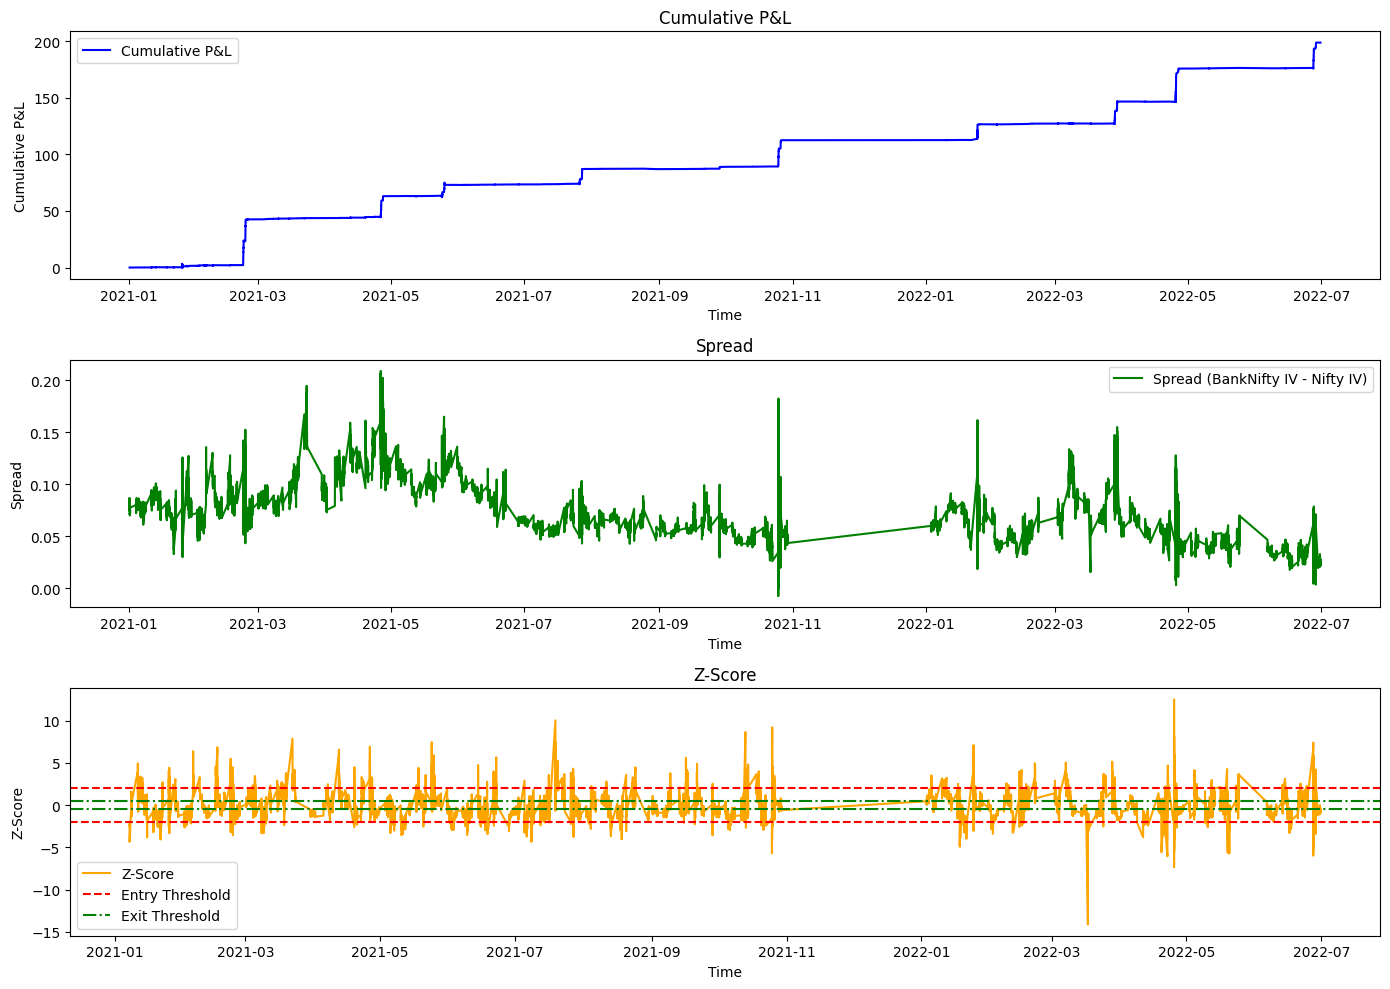

In [ ]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt

def preprocess_data(df):
    """
    Preprocess the data by handling missing values and filtering out:
    - Entries outside the Indian market trading hours (9:15 AM to 3:30 PM)
    - Days that are holidays (where all values for banknifty and nifty during trading hours are constant)
    """
    # Forward fill missing values for 'banknifty' and 'nifty'
    df[['banknifty', 'nifty']] = df[['banknifty', 'nifty']].ffill()
    
    # Ensure the index is a DatetimeIndex
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("The DataFrame index must be a DatetimeIndex.")
    
    # Filter out rows outside trading hours (9:15 AM to 3:30 PM)
    df = df.between_time('09:15', '15:30')
    
    # Remove holiday days
    # A holiday is defined as a day where all values for banknifty and nifty are constant
    def is_holiday(group):
        return (group['banknifty'].nunique() == 1) and (group['nifty'].nunique() == 1)
    
    # Group by day and remove groups that qualify as holidays
    non_holiday_groups = [
        group for _, group in df.groupby(df.index.date) if not is_holiday(group)
    ]
    
    # Reassemble the DataFrame from non-holiday groups
    if non_holiday_groups:
        df = pd.concat(non_holiday_groups)
    else:
        df = pd.DataFrame()  # return an empty DataFrame if no valid days exist
    
    return df


def calculate_spread_and_zscore(df, lookback_window=30):
    """
    Calculate spread and z-score
    """
    # Calculate spread
    df['spread'] = (df['banknifty'] - df['nifty'])
    
    # Calculate rolling mean and std for z-score
    df['spread_mean'] = df['spread'].rolling(window=lookback_window).mean()
    df['spread_std'] = df['spread'].rolling(window=lookback_window).std()
    
    # Calculate z-score
    df['zscore'] = (df['spread'] - df['spread_mean']) / df['spread_std']
    
    return df


def generate_positions(df, entry_threshold=2, exit_threshold=0):
    """
    Generate trading positions based on z-score while ensuring that:
      - A new trade is only initiated after closing the previous one.
      - In case of a sudden reversal, the active trade is closed before opening the new one.
    
    The logic:
      - If no trade is active (current_position == 0):
            If zscore <= -entry_threshold, open a long position (current_position = 1).
            If zscore >= entry_threshold, open a short position (current_position = -1).
      - If a trade is active:
            For a long trade (current_position == 1):
                Exit when zscore >= -exit_threshold.
                If, after exit, zscore >= entry_threshold, immediately open a short trade.
            For a short trade (current_position == -1):
                Exit when zscore <= exit_threshold.
                If, after exit, zscore <= -entry_threshold, immediately open a long trade.
    
    Returns a DataFrame column 'position' with the active position at each time step.
    """
    positions = [0] * len(df)
    current_position = 0

    # Loop over the rows by index
    for i in range(len(df)):
        z = df.iloc[i]['zscore']

        if current_position == 0:
            # No active trade, so check for entry signal.
            if z <= -entry_threshold:
                current_position = 1    # Enter long spread.
            elif z >= entry_threshold:
                current_position = -1   # Enter short spread.
        else:
            # There is an active trade.
            if current_position == 1:
                # For a long trade, exit when the zscore rises to or above -exit_threshold.
                if z >= -exit_threshold:
                    # Exit the long position.
                    current_position = 0
                    # Check if an immediate short signal is generated.
                    if z >= entry_threshold:
                        current_position = -1
            elif current_position == -1:
                # For a short trade, exit when the zscore falls to or below exit_threshold.
                if z <= exit_threshold:
                    current_position = 0
                    # Check if an immediate long signal is generated.
                    if z <= -entry_threshold:
                        current_position = 1
        
        positions[i] = current_position

    df['position'] = positions
    return df


def calculate_pnl(df):
    """
    Calculate P&L using the given formula: P/L = Spread × (Time To Expiry)^0.7
    """
    # Calculate raw P&L for each minute
    df['raw_pnl'] = df['spread']*(df['tte']**0.7)
    
    # Calculate actual P&L based on positions
    df['pnl'] = df['position'].shift(1) * (df['raw_pnl'] - df['raw_pnl'].shift(1))
    
    # Calculate cumulative P&L
    df['cumulative_pnl'] = df['pnl'].cumsum()
    
    return df

def extract_trades(df):
    """
    Extract discrete trade events from the DataFrame and return a trades DataFrame.
    
    We assume:
      - A trade is initiated when the position changes from 0 to a nonzero value.
      - A trade is closed when the position returns to 0 or reverses sign.
      - For each trade, we record the entry timestamp (start_date), exit timestamp (end_date),
        entry values (nifty, banknifty, tte, and raw_pnl) and similarly for exit.
      - Net profit is computed as the difference in the cumulative_pnl between exit and entry.
      - Invested value is estimated as the absolute value of raw_pnl at the trade entry.
    """
    trades = []
    trade_active = False
    trade_entry_row = None  # store the row at entry
    entry_index = None       # store the index of entry
    current_trade_type = 0

    # Loop over the DataFrame rows in order.
    for i, row in df.iterrows():
        pos = row['position']
        if not trade_active and pos != 0:
            # New trade entry detected.
            trade_active = True
            entry_index = i
            trade_entry_row = row.copy()  # record the trade entry details
            current_trade_type = pos
        elif trade_active:
            # A trade is active. We detect exit if:
            #   - The position becomes 0 (closed)
            #   - Or the position reverses (for example from 1 to -1 or vice versa)
            if pos == 0 or pos != current_trade_type:
                # We treat the exit as the last row where the trade was still active.
                # (If a reversal occurs, the exit and reentry might be simultaneous.)
                # Here, we choose the current row as the exit point.
                exit_index = df.index[df.index.get_loc(i)]
                trade_exit_row = df.loc[exit_index].copy()
                
                # Compute net profit: difference in cumulative_pnl
                net_profit = trade_exit_row['cumulative_pnl'] - trade_entry_row['cumulative_pnl']
                
                # Use the absolute raw_pnl at entry as the invested capital.
                invested_value = abs(trade_entry_row['raw_pnl'])
                
                trade = {
                    'start_date': entry_index,
                    'end_date': exit_index,
                    'entry_nifty': trade_entry_row['nifty'],
                    'entry_banknifty': trade_entry_row['banknifty'],
                    'entry_tte': trade_entry_row['tte'],
                    'entry_raw_pnl': trade_entry_row['raw_pnl'],
                    'exit_nifty': trade_exit_row['nifty'],
                    'exit_banknifty': trade_exit_row['banknifty'],
                    'exit_tte': trade_exit_row['tte'],
                    'exit_raw_pnl': trade_exit_row['raw_pnl'],
                    'trade_type': current_trade_type,
                    'net_profit': net_profit,
                    'invested_value': invested_value
                }
                trades.append(trade)
                # Reset trade state.
                trade_active = False
                trade_entry_row = None
                current_trade_type = 0
                # If the current row (row at index i) indicates a new entry immediately (reversal),
                # that will be caught in the next iteration.
                
    trades_df = pd.DataFrame(trades)
    return trades_df



def calculate_metrics(df,trades_df):
    """
    Calculate key performance metrics
    """
    # Calculate metrics
    total_pnl = df['pnl'].sum()
    sharpe_ratio = np.sqrt(375*5) * df['pnl'].mean() / df['pnl'].std() # weekly returns 
    max_drawdown = (df['cumulative_pnl'].cummax() - df['cumulative_pnl']).max()
    total_invested = trades_df['invested_value'].sum()
    trade_count = len(trades_df)
    
    metrics = {
        'Total P&L': total_pnl,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Max Drawdown%' : 100*max_drawdown/df['cumulative_pnl'].max(),
        'Average Invested Value': total_invested/trade_count,
        'Total Trades': trade_count,
        'Total Invested value': total_invested
    }
    
    return metrics

def run_strategy(data_path, lookback_window=30, entry_threshold=2, exit_threshold=0):
    """
    Run the complete trading strategy
    """
    # Read data
    df = pd.read_parquet(data_path)
    
    # Process data
    df = preprocess_data(df)
    df = calculate_spread_and_zscore(df, lookback_window)
    df = generate_positions(df, entry_threshold, exit_threshold)
    df = calculate_pnl(df)
    trades_df = extract_trades(df)

    # Calculate metrics
    metrics = calculate_metrics(df,trades_df)
    
    return df, metrics,trades_df

def output_results(output_file,trades_file):
    # Output the metrics to console
    print("Performance Metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value:.2f}")

    #output trades to the console
    print("Trades:")
    print(trades_df.head())


    # Save the final dataframe to CSV
    df.to_csv(output_file, index=True)
    trades_df.to_csv(trades_file, index=True)
    print("Output saved to output.csv")

    # --------------------- Plotting ---------------------
    # Plot cumulative P&L, spread, and z-score in subplots.
    plt.figure(figsize=(14, 10))

    # Plot cumulative P&L
    plt.subplot(3, 1, 1)
    plt.plot(df.index, df['cumulative_pnl'], label='Cumulative P&L', color='blue')
    plt.title('Cumulative P&L')
    plt.xlabel('Time')
    plt.ylabel('Cumulative P&L')
    plt.legend()

    # Plot spread
    plt.subplot(3, 1, 2)
    plt.plot(df.index, df['spread'], label='Spread (BankNifty IV - Nifty IV)', color='green')
    plt.title('Spread')
    plt.xlabel('Time')
    plt.ylabel('Spread')
    plt.legend()

    # Plot z-score
    plt.subplot(3, 1, 3)
    plt.plot(df.index, df['zscore'], label='Z-Score', color='orange')
    plt.axhline(entry_con, color='red', linestyle='--', label='Entry Threshold')
    plt.axhline(-entry_con, color='red', linestyle='--')
    plt.axhline(exit_con, color='green', linestyle='-.', label='Exit Threshold')
    plt.axhline(-exit_con, color='green', linestyle='-.')
    plt.title('Z-Score')
    plt.xlabel('Time')
    plt.ylabel('Z-Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Run the strategy
loop = 1875
entry_con = 2
exit_con = 0.5
df, metrics,trades_df = run_strategy("data.parquet", lookback_window=loop, entry_threshold=entry_con, exit_threshold=exit_con)
output_results('Zoutput.csv','Ztrades.csv')




Performance Metrics:
Total P&L: 176.17
Sharpe Ratio: 2.01
Max Drawdown: 2.64
Max Drawdown%: 1.50
Average Invested Value: 0.53
Total Trades: 4218.00
Total Invested value: 2224.16
Trades:
           start_date            end_date  entry_nifty  entry_banknifty  \
0 2021-01-01 10:08:00 2021-01-01 10:17:00     0.190717         0.266509   
1 2021-01-01 11:13:00 2021-01-01 11:16:00     0.189605         0.264591   
2 2021-01-01 11:38:00 2021-01-01 11:41:00     0.189087         0.262649   
3 2021-01-01 11:54:00 2021-01-01 11:59:00     0.188870         0.260947   
4 2021-01-01 12:31:00 2021-01-01 12:32:00     0.184932         0.255003   

   entry_tte  entry_raw_pnl  exit_nifty  exit_banknifty  exit_tte  \
0       27.0       0.761329    0.190093        0.268428      27.0   
1       27.0       0.753243    0.187922        0.265271      27.0   
2       27.0       0.738933    0.189253        0.265745      27.0   
3       27.0       0.724026    0.188835        0.262748      27.0   
4       27.0      

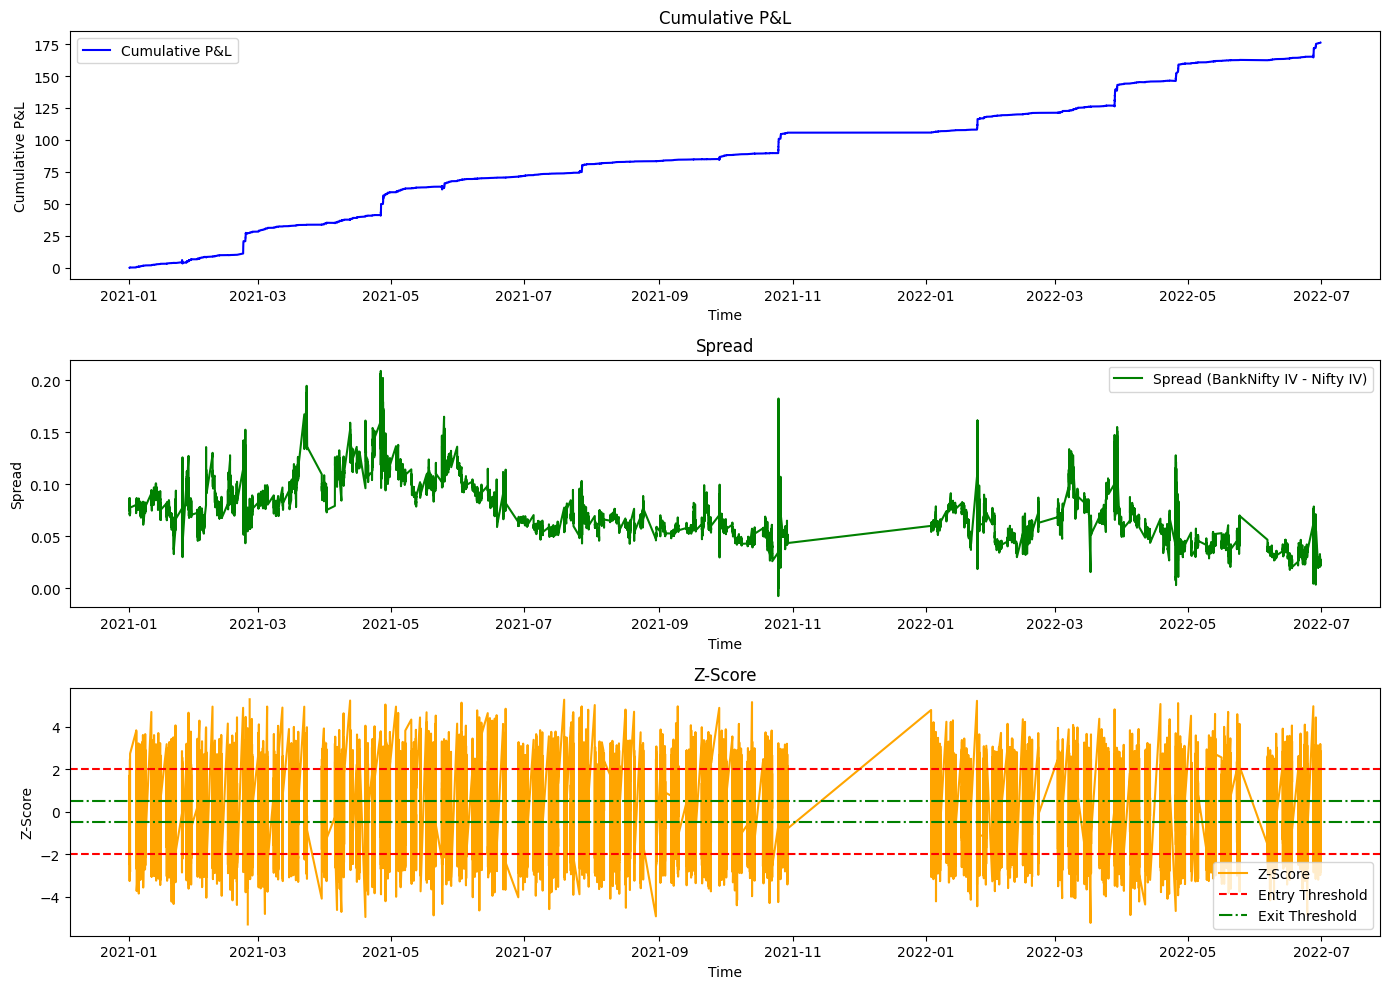

In [ ]:

def calculate_spread_and_zscore_new(df, lookback_window=30):
    """
    Calculate spread and z-score
    """
    # Calculate spread
    df['spread'] = (df['banknifty'] - df['nifty'])
    
    # Calculate rolling mean and std for z-score
    df['spread_mean'] = df['spread'].rolling(window=lookback_window).mean()
    df['spread_std'] = df['spread'].rolling(window=lookback_window).std()
    
    # Calculate z-score
    df['zscore'] = (df['spread'] - df['spread_mean']) / df['spread_std']
    
    return df


def generate_positions_new(df, entry_threshold=2, exit_threshold=0):
    """
    Generate trading positions based on z-score while ensuring that:
      - A new trade is only initiated after closing the previous one.
      - In case of a sudden reversal, the active trade is closed before opening the new one.
    
    The logic:
      - If no trade is active (current_position == 0):
            If zscore <= -entry_threshold, open a long position (current_position = 1).
            If zscore >= entry_threshold, open a short position (current_position = -1).
      - If a trade is active:
            For a long trade (current_position == 1):
                Exit when zscore >= -exit_threshold.
                If, after exit, zscore >= entry_threshold, immediately open a short trade.
            For a short trade (current_position == -1):
                Exit when zscore <= exit_threshold.
                If, after exit, zscore <= -entry_threshold, immediately open a long trade.
    
    Returns a DataFrame column 'position' with the active position at each time step.
    """
    positions = [0] * len(df)
    current_position = 0

    # Loop over the rows by index
    for i in range(len(df)):
        z = df.iloc[i]['zscore']

        if current_position == 0:
            # No active trade, so check for entry signal.
            if z <= -entry_threshold:
                current_position = 1    # Enter long spread.
            elif z >= entry_threshold:
                current_position = -1   # Enter short spread.
        else:
            # There is an active trade.
            if current_position == 1:
                # For a long trade, exit when the zscore rises to or above -exit_threshold.
                if z >= -exit_threshold:
                    # Exit the long position.
                    current_position = 0
                    # Check if an immediate short signal is generated.
                    if z >= entry_threshold:
                        current_position = -1
            elif current_position == -1:
                # For a short trade, exit when the zscore falls to or below exit_threshold.
                if z <= exit_threshold:
                    current_position = 0
                    # Check if an immediate long signal is generated.
                    if z <= -entry_threshold:
                        current_position = 1
        
        positions[i] = current_position

    df['position'] = positions
    return df


def calculate_pnl_new(df):
    """
    Calculate P&L using the given formula: P/L = Spread × (Time To Expiry)^0.7
    """
    # Calculate raw P&L for each minute
    df['raw_pnl'] = df['spread']*(df['tte']**0.7)
    
    # Calculate actual P&L based on positions
    df['pnl'] = df['position'].shift(1) * (df['raw_pnl'] - df['raw_pnl'].shift(1))
    
    # Calculate cumulative P&L
    df['cumulative_pnl'] = df['pnl'].cumsum()
    
    return df


def calculate_metrics_new(df,trades_df):
    """
    Calculate key performance metrics
    """
    # Calculate metrics
    total_pnl = df['pnl'].sum()
    sharpe_ratio = np.sqrt(375*5) * df['pnl'].mean() / df['pnl'].std() # weekly returns 
    max_drawdown = (df['cumulative_pnl'].cummax() - df['cumulative_pnl']).max()
    total_invested = trades_df['invested_value'].sum()
    trade_count = len(trades_df)
    
    metrics = {
        'Total P&L': total_pnl,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Max Drawdown%' : 100*max_drawdown/df['cumulative_pnl'].max(),
        'Average Invested Value': total_invested/trade_count,
        'Total Trades': trade_count,
        'Total Invested value': total_invested
    }
    
    return metrics

def run_strategy_new(data_path, lookback_window=30, entry_threshold=2, exit_threshold=0):
    """
    Run the complete trading strategy
    """
    # Read data
    df = pd.read_parquet(data_path)
    
    # Process data
    df = preprocess_data(df)
    df = calculate_spread_and_zscore_new(df, lookback_window)
    df = generate_positions_new(df, entry_threshold, exit_threshold)
    df = calculate_pnl_new(df)
    trades_df = extract_trades(df)

    # Calculate metrics
    metrics = calculate_metrics_new(df,trades_df)
    
    return df, metrics,trades_df


# Run the strategy
loop = 30
entry_con = 2
exit_con = 0.5
df, metrics,trades_df = run_strategy_new("data.parquet", lookback_window=loop, entry_threshold=entry_con, exit_threshold=exit_con)
output_results('NewOutput.csv','NewTrades.csv')
